GitHub Repo: https://github.com/Aylin-Ab/dsci100-2025w1-group27

In [1]:
# Load all the libraries needed for running this notebook
library(tidyverse)
library(repr)
library(ggplot2)
library(tidymodels)
options(repr.matrix.max.rows = 4) #limits output of dataframes to 4 rows

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.6     ✔ rsample      1.2.1
✔ dials        1.3.0     ✔ tune         1.1.2
✔ infer        1.0.7     ✔ workflows    1.1.4
✔ modeldata    1.4.0     ✔ workflowsets 1.0.1
✔ parsnip      1.2.1     ✔ yardstick    1.3.1
✔ recipes      1.1.0     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filt

# Identifying Predictors of Gaming Newsletter Subscription in Minecraft Players

## **Introduction**

A research group in the Department of Computer Science at UBC has been running a Minecraft server to collect data on how people play video games. One way the group can recruit and stay connected with players is through game-related newsletters, so understanding which types of players are likely to subscribe to such newsletters is useful. If the researchers can predict which players are more likely to subscribe, they can tailor their recruitment strategies and allocate their resources more effectively. The server has recorded several categorical, logical, and numerical data points about player behaviour, giving us enough information to explore patterns in the data and build a meaningful predictive model.

The broader research question guiding this project is: What player characteristics and behaviours are most predictive of subscribing to a game-related newsletter, and how do these features differ between various player types? The specific question we aim to answer is: **Can the total number of hours played and user age predict whether an individual will subscribe to the newsletter?**

Because the subscribe variable is categorical (subscribed vs. not subscribed), our analysis is a classification problem rather than a regression task. We ***use only the `players.csv` dataset***, as it contains all the variables required for this analysis: `Age` and `played_hours` as the predictor variables, and subscribe as the response/outcome variable. We will then use K-NN classification model to examine whether player age and play hours can predict newsletter subscription.

### Loading & Describing players.csv

The `players.csv` dataset includes a list of all unique players along with their recorded information. It consists of 196 observations (rows) and 7 variables (columns). Each row represents the data collected for a single player. The dataset contains seven variables in total:
- Five categorical variables: `experience,` `hashedEmail,` `name,` `gender` and `subscribe` (logical).
- Two numerical variables: `Age` and `played_hours`.

>

Below is a snippet of the dataset which has been loaded into R using `read_csv()`:

In [46]:
players <- read_csv("https://raw.githubusercontent.com/Aylin-Ab/dsci100-2025w1-group27/refs/heads/main/players.csv")
players 

Rows: 196 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): experience, hashedEmail, name, gender
dbl (2): played_hours, Age
lgl (1): subscribe

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


experience,subscribe,hashedEmail,played_hours,name,gender,Age
<chr>,<lgl>,<chr>,<dbl>,<chr>,<chr>,<dbl>
Pro,TRUE,f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d,30.3,Morgan,Male,9
Veteran,TRUE,f3c813577c458ba0dfef80996f8f32c93b6e8af1fa939732842f2312358a88e9,3.8,Christian,Male,17
⋮,⋮,⋮,⋮,⋮,⋮,⋮
Amateur,FALSE,f19e136ddde68f365afc860c725ccff54307dedd13968e896a9f890c40aea436,2.3,Harlow,Male,17
Pro,TRUE,d9473710057f7d42f36570f0be83817a4eea614029ff90cf50d8889cdd729d11,0.2,Ahmed,Other,NA


Here's an explanation of what each variable means:

| Variable            | Description                                                                                                                                                        |
| ------------------- | ------------------------------------------------------------------------------------------------------------------------------------------------------------------ |
| hashedEmail         | These strings of characters are encrypted email addresses that undergo "hashing" to make them secure                                                            
| experience          | Classifies the user based on how much experience they have playing the game |
| subscribe           | Logical variable that states whether or not the user has subscribed to the game-related newsletter|
| played_hours        | Total amount of hours that the user has logged on the server|
| name                | User display name                                                                                                                                                           |
| gender              | User gender   |
| Age                 | User age         |



Below are the summary statistics for the variables in the players dataset, showing the number of observations for each variable, number of missing values in the three variables used in our KNN model, and other key metrics such as the minimum, mean, and maximum for the numerical variables.

In [47]:
summary(players)


# count the number of missing values in the variables used for the KNN model 
players |> summarise(subscribe_missing    = sum(is.na(subscribe)),
                     played_hours_missing = sum(is.na(played_hours)),
                     age_missing = sum(is.na(Age)))

  experience        subscribe       hashedEmail         played_hours    
 Length:196         Mode :logical   Length:196         Min.   :  0.000  
 Class :character   FALSE:52        Class :character   1st Qu.:  0.000  
 Mode  :character   TRUE :144       Mode  :character   Median :  0.100  
                                                       Mean   :  5.846  
                                                       3rd Qu.:  0.600  
                                                       Max.   :223.100  
                                                                        
     name              gender               Age       
 Length:196         Length:196         Min.   : 9.00  
 Class :character   Class :character   1st Qu.:17.00  
 Mode  :character   Mode  :character   Median :19.00  
                                       Mean   :21.14  
                                       3rd Qu.:22.75  
                                       Max.   :58.00  
                               

subscribe_missing,played_hours_missing,age_missing
<int>,<int>,<int>
0,0,2


## **Methods and Results**

In this section, we describe our analysis workflow, from wrangling and cleaning the raw player data to training and evaluating a k-nearest neighbour (KNN) classifier. All code is written in R using the tidyverse and tidymodels packages. Our goal is to use two simple player characteristics, player age and total played hours on the server, to predict whether a player will subscribe to the game-related newsletter. Before developing the model, we explored the data visually to identify potential trends.

### Exploratory Data Analysis & Visualization

Before building our predictive model, we first examined simple relationships within the dataset to understand potential patterns. Figure 1 visualizes the mean number of hours played for each age group in a scatter plot. To create this plot, we grouped the data by `Age` and calculated the mean of `played_hours`, then plotted these values using ggplot2. This exploratory plot helps identify whether playtime systematically varies with player age.

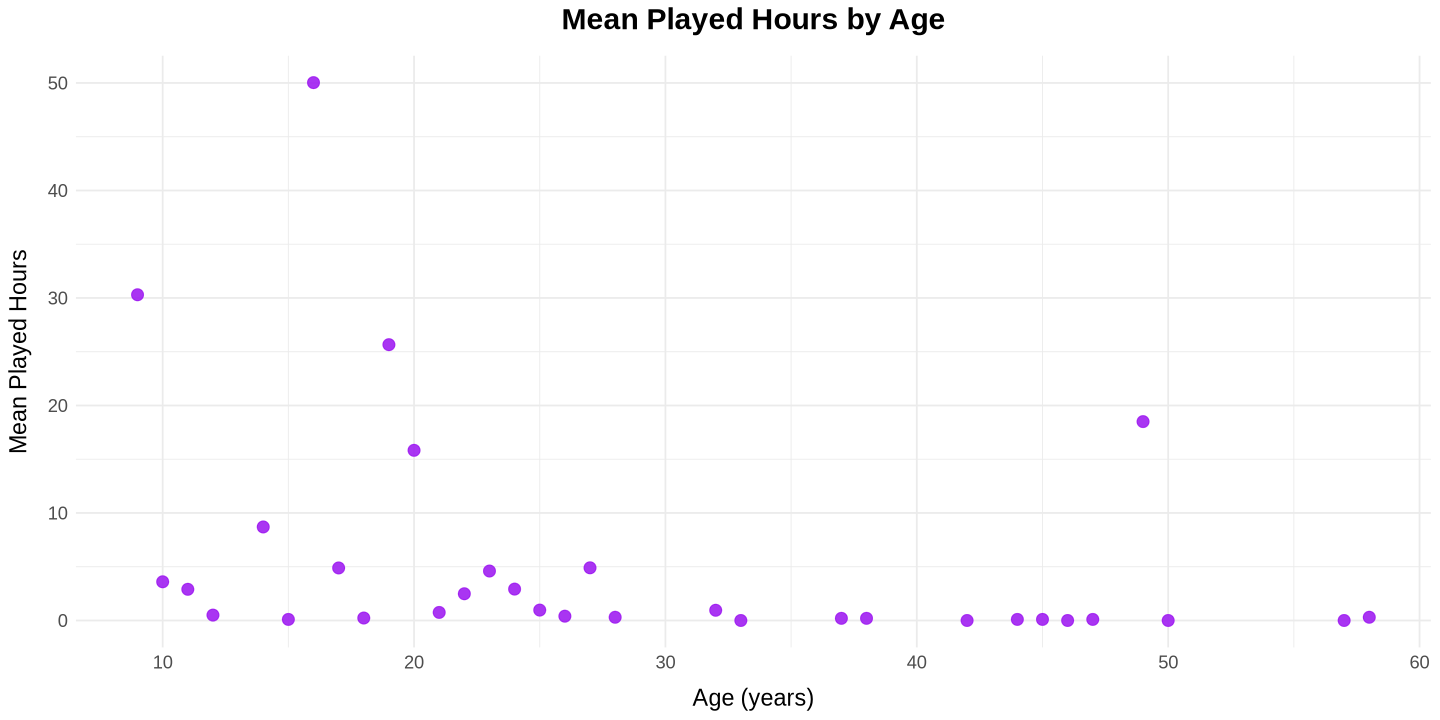

In [53]:
options(repr.plot.width = 12, repr.plot.height = 6)

age_means  <- players |>
  group_by(Age) |>
  summarise(mean_played_hours = mean(played_hours, na.rm = TRUE))


age_vs_hours <- age_means |>
    ggplot(aes(x = Age, y = mean_played_hours)) +
    geom_point(color = "purple", size = 3, alpha = 0.9) +
    labs(
    title = "Mean Played Hours by Age",
    x = "Age (years)",
    y = "Mean Played Hours") +
    theme_minimal() +
    theme(
        plot.title = element_text(size = 18, face = "bold", hjust = 0.5, margin = margin(b = 12)),
        axis.title = element_text(size = 14),
        axis.text = element_text(size = 11),
        axis.title.x = element_text(margin = margin(t = 10)),
        axis.title.y = element_text(margin = margin(r = 10)))
age_vs_hours

**Figure 1.** Mean played hours by age. 

The plot above shows that there is no strong relationship between a player's age and the average amount of hours spent on the server. 

To further explore how our predictor variables interact, we next visualized the relationship between age and played hours together while distinguishing players by their subscription status. The scatter plot in Figure 2 provides a clearer view of whether certain age groups or playtime levels correspond to a higher likelihood of subscribing, giving us an early visual sense of how well the two classes (subscriber vs non-subscriber) might separate before modeling.

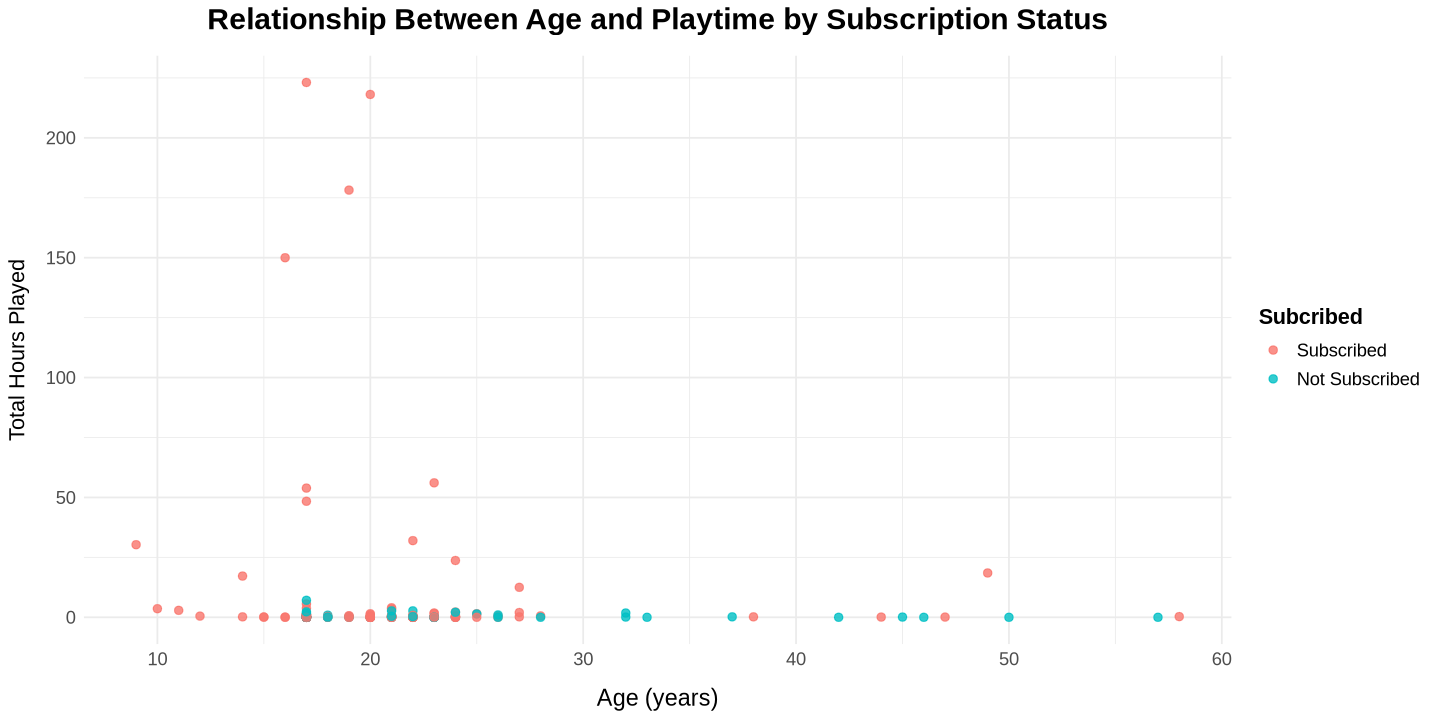

In [54]:
options(repr.plot.width = 12, repr.plot.height = 6)

predictors_vs_subscription <- players |>
    ggplot(aes(x = Age, y = played_hours, color = subscribe)) +
    geom_point(size = 2, alpha = 0.8) +
    labs(
        title = "Relationship Between Age and Playtime by Subscription Status",
        x = "Age (years)",
        y = "Total Hours Played", 
        color = "Subcribed") +
    theme_minimal() +
    theme(
        plot.title = element_text(size = 18, face = "bold", hjust = 0.5, margin = margin(b = 12)),
        axis.title.x = element_text(size = 14, margin = margin(t = 12)),
        axis.title.y = element_text(size = 13, margin = margin(r = 10)),
        axis.text = element_text(size = 11),
        legend.title = element_text(size = 13, face = "bold"),
        legend.text = element_text(size = 11))

predictors_vs_subscription

**Figure 2.** Age versus played hours coloured by subscription status.

The data visualisation above allows us to see that everyone who played more than ~25 hours on the server subscribed to the newsletter, indicating a possible relationship between total hours played and whether a user subscribes to the game-related newsletter. However, aside from that, the plot doesn't reveal strong or consistent patterns that distinguish subscribers from non-subscribers. This suggests that our K-NN model will probably have only modest predictive performance.

Finally, we created a bar plot (Figure 3) to see how many players subscribed to the game-related newsletter and how many did not. This information is useful in deciding the range of *k* values to test during tuning and cross-validation. If one class has fewer data points than the other, using a large k can cause the model to be biased and mostly predict the majority class. 

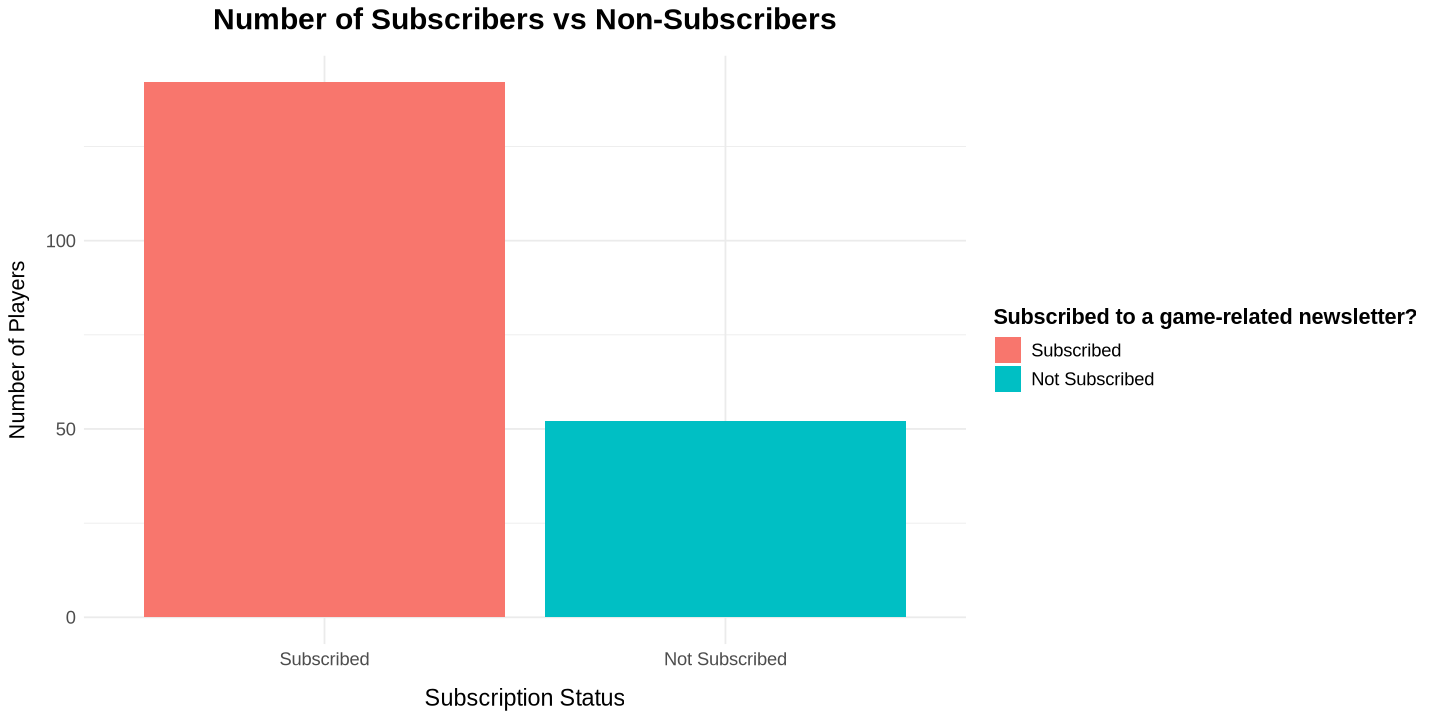

In [55]:
subscribe_plot <- players |>
    ggplot(aes(x = subscribe, fill = subscribe)) +
    geom_bar() +
    labs(x = "Subscription Status", y = "Number of Players", fill = "Subscribed to a game-related newsletter?") +
    ggtitle("Number of Subscribers vs Non-Subscribers") +
    theme_minimal() +
    theme(
          plot.title = element_text(size = 18, face = "bold", hjust = 0.5, margin = margin(b = 12)),
          axis.title.x = element_text(size = 14, margin = margin(t = 12)),
          axis.title.y = element_text(size = 13, margin = margin(r = 10)),
          axis.text = element_text(size = 11),
          legend.title = element_text(size = 13, face = "bold"),
          legend.text = element_text(size = 11))
         
subscribe_plot

**Figure 3.** Comparison of the number of players who subscribed to the newsletter and those who did not.

The plot above shows that most players in the dataset (~ 140) subscribed to the game-related newsletter, which is more than twice the number of non-subscribers (~ 50). This imbalance means the subscription (our outcome variable) is not evenly distributed, which may make it harder for the model to accurately learn patterns for the smaller non-subscriber group. Based on this, we can choose to tune the model on k values up to 20.

### Wrangling & Cleaning

Before creating our KNN classifier, we need to wrangle and clean the data for the variables we're using: `Age`, `played_hours`, and `subscribe`.
First, we convert `subscribe` into a factor variable with 2 levels ("Subscribed" and "Not Subscribed"). And then, using `na.omit()` we remove any rows in the data that has missing values. This gives us a clean dataset that's ready for modelling.

In [56]:
#  convert subscribe column into a factor (TRUE = Subscribed, FALSE = Not Subscribe)
players <- players |>
    mutate(subscribe = factor(subscribe, levels = c(TRUE, FALSE), 
                              labels = c("Subscribed", "Not Subscribed")))

# remove NA values in any columns of the dataframe
players <- players |>
    na.omit()

### Modeling

Since our predictors are numerical and the outcome variable (`subscribe`) is categorical, K-NN Classification is an appropriate model for this task.

To build the model, we will only use the `players` data set. First, we split the data into training and testing sets with an **80:20** training:testing ratio, and create a recipe that centers and scales all numeric predictors. This step is important because K-NN relies on distance calculations, so the predictors need to be on similar scales. Otherwise, one predictor variable could dominate the distance calculations and therefore bias the predictions.

We then perform a 5-fold cross-validation and tune a range of *K* values from 1 to 20 to find the optimal number of neighbors. Testing a range of *k* values allows us to find the point where our classifier performs best (i.e., higher accuracy) without over or underfitting the training dataset. 


After evaluating the results of the tuning & cross-validatiouse using `collect_metrics()`, we choose the *k* value that has the highest mean accuracy. This ideal K value will then be used to fit our model on the training set. And finally, our model will be tested on the testing set to see how well the model predicts subscription status for new, unseen data.

*Limitations:*

A limitation of this model is that tuning 20 different k values during cross-validation can be computationally intensive and may take longer to run, especially with larger datasets. Furthermore, KNN classification does not fit a visible line or equation through the data like linear regression does (with clear coefficients), so it’s harder to see which variable is actually the most predictive of the outcome.

#### Train-test split

We use `set.seed(1234)` for this and every other step of our model analysis to make sure that the code is reproducible. We then split the cleaned data into an 80% training set and a 20% test set using `initial_split()` with stratification on `subscribe`. This ensures that both the training and test sets have the same proportion of subscribers and non-subscribers as the original dataset.

In [52]:
set.seed(1234)
# split players into training and testing set, using an 80:20 split ratio
players_split <- initial_split(players, prop = 0.8 , strata = subscribe)  
players_train <- training(players_split)   
players_test <- testing(players_split)

#### Training, evaluating, and tuning the model

We first build a K-NN classification model specification with tuning on the number of neighbors. We then create a tidymodels recipe using `Age` and `played_hours` as predictors and `subscribe` as the outcome and standardize both predictors using `step_scale()` and `step_center()`. Next, we combine the recipe and model specification in a workflow and perform cross-validation on the training set for *k* values from 1-20. Finally, we collect the mean accuracy for each *k* and plot them to identify the optimal number of neighbors (Figure 4).

neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
17,accuracy,binary,0.7469892,5,0.0104909,Preprocessor1_Model17


Warning message:
“Removed 1 row containing missing values or values outside the scale range
(`geom_point()`).”


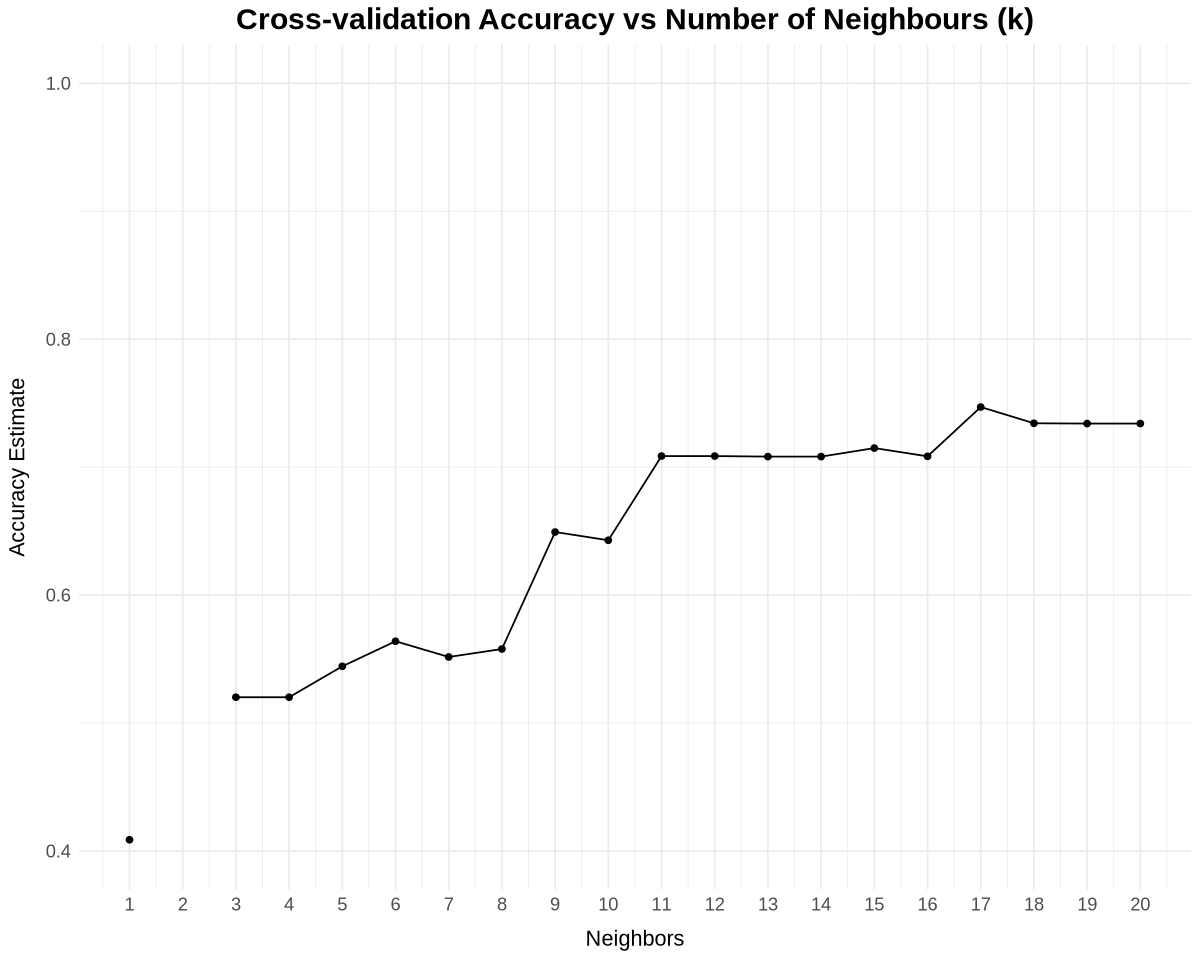

In [25]:
set.seed(1234) 
# perform tuning and cross-validation to select the best k with highest accuracy

# set knn model specification to tuning
knn_tune <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
    set_engine("kknn") |>
    set_mode("classification")

# specifiy the number of folds for cross-validation
players_vfold <- vfold_cv(players_train, v = 5, strata = subscribe)

# create a recipe to be used for cross-validation & tuning
players_recipe <- recipe(subscribe ~ Age + played_hours, data = players_train) |>
    step_scale(all_predictors()) |>
    step_center(all_predictors())

# create a vector with all k values we want to perform tuning on
k_vals <- tibble(neighbors = seq(from = 1, to = 20, by = 1))

# create a workflow that combines the recipe and knn_tune model spec, and collect the accuray metric for each k
knn_results <- workflow() |>
      add_recipe(players_recipe) |>
      add_model(knn_tune) |>
      tune_grid(resamples = players_vfold, grid = k_vals) |>
      collect_metrics()

# select the k value with highest level of accuracy
accuracies <- knn_results |>
    filter(.metric == "accuracy") 

accuracie_max <- accuracies |>
    slice_max(mean)
accuracie_max

options(repr.plot.width = 10, repr.plot.height = 8)
cross_val_plot <- ggplot(accuracies, aes(x = neighbors, y = mean)) +
    geom_point() +
    geom_line() +
    labs(x = "Neighbors", y = "Accuracy Estimate") +
    ggtitle("Cross-validation Accuracy vs Number of Neighbours (k)") +
    scale_x_continuous(breaks = seq(0, 40, by = 1)) +  # adjusting the x-axis
    scale_y_continuous(limits = c(0.4, 1.0)) + # adjusting the y-axis
    theme_minimal() +
    theme(
    plot.title = element_text(size = 18, face = "bold", hjust = 0.5),
    axis.title.x = element_text(size = 13, margin = margin(t = 10)),  
    axis.title.y = element_text(size = 13, margin = margin(r = 10)),
    axis.text = element_text(size = 11))

cross_val_plot

**Figure 4.** Cross-validated accuracy of the K-NN classifier for different numbers of neighbors. 

The chosen value of *k* corresponds to the highest accuracy and balances overfitting and underfitting. The plot shows how the model’s predictive accuracy changes as *k* increases from 1 to 20. Accuracy improves rapidly between *k* = 1 and *k* = 10, after which the curve begins to flatten. The highest accuracy occurs around *k* = 17, which will be selected for the final model. This value balances model complexity and generalization: smaller *k* values risk overfitting the model, while larger *k* values may underfit the data.

#### Final Model and Evaluation

Using the best value of *k* from cross-validation (*k* = 17), we fit a final K-NN model on the full training set. We then predict subscription status (class labels) for the held-out test set and assess our classifier's performance using the `metrics()` function and obtain the estimated accuracy of our model. 

In [29]:
set.seed(1234) 

# create a model spec with the best value of k (17)
knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 17) |>
    set_engine("kknn") |>
    set_mode("classification")

# fit the model on the training set
players_fit <- workflow() |>
    add_recipe(players_recipe) |>
    add_model(knn_spec) |>
    fit(data = players_train)

In [39]:
set.seed(1234) 
# conduct prediction on the dataset (test on the testing set!)

players_predictions <- predict(players_fit, players_test) |>
    bind_cols(players_test)
players_predictions 

players_metrics <- players_predictions |>
    metrics(truth = subscribe, estimate = .pred_class)
players_metrics

.pred_class,experience,subscribe,hashedEmail,played_hours,name,gender,Age
<fct>,<chr>,<fct>,<chr>,<dbl>,<chr>,<chr>,<dbl>
Subscribed,Pro,Subscribed,f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d,30.3,Morgan,Male,9
Subscribed,Veteran,Not Subscribed,b674dd7ee0d24096d1c019615ce4d12b20fcbff12d79d3c5a9d2118eb7ccbb28,0.0,Blake,Male,17
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
Subscribed,Amateur,Subscribed,24d4892c2c3ce11d3e54c3bf31ee218901cac7a2f564911d67424c8fdf0874fe,32.0,Sidney,Male,22
Subscribed,Amateur,Not Subscribed,f19e136ddde68f365afc860c725ccff54307dedd13968e896a9f890c40aea436,2.3,Harlow,Male,17


.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.70000000
kap,binary,-0.04803493


Looking at the `.estimate` value above, we can see that the estimated accuracy of our classifier on the test data was 70%.

We can also create a confusion matrix (Figure 5) to get a more comprehensive picture of the model's performance. 

In [31]:
# Create a confusion matrix to evaluate the performance of the model
players_conf_mat <- players_predictions |>
    conf_mat(truth = subscribe, estimate = .pred_class)
players_conf_mat 

                Truth
Prediction       Subscribed Not Subscribed
  Subscribed             28             11
  Not Subscribed          1              0

**Figure 5.** Confusion matrix for the final KNN model on the test set. 

As shown above, the model correctly identified 28 subscribed players as subscribers, and incorrectly classified 1 subscribed player as a non-subscriber. This shows that the model performs reasonably well when predicting the *subscribed* class.

Treating "Subscribed" as the positive class, classifier's precision and recall is:

In [43]:
Percision = 28/39
Recall = 28/29
Accuracy = 0.70000000

All_Metrics = tibble(percision, recall, accuracy)
All_Metrics

percision,recall,accuracy
<dbl>,<dbl>,<dbl>
0.7179487,0.9655172,0.7


**Figure 6.** K-NN model's percision, recall, and accuracy metrics.

Based on Figure 6, the model achieved a precision of about 0.72, meaning that when it predicts a player is subscribed, it is correct roughly 72% of the time. Its recall is much higher at around 97%, which shows that the model successfully identifies almost all actual subscribers. 

These results show that our classifier **strongly over-predicts the *Subscribed*** class and struggles to detect players who did not subscribe. In other words, it's very good at detecting subscribers, but its performance is very weak when it comes to correctly classifying non-subscribers.

## **Discussion**

In this project, we used a k-nearest neighbor (KNN) classifier with two predictors, `Age` and `played_hours`, to predict whether a player would subscribe to a game-related newsletter. After tuning *k* using five-fold cross-validation, we found that the best value, *k* = 17, gave a model accuracy of ~70% on the test set. In other words, using only age and total time spent on the server, the model correctly predicted a player’s subscription status around seven times out of ten. The confusion matrix further showed that the model tends to predict “Subscribed” much more often (almost all the time!), which explains why the accuracy is moderate rather than high.

Although the accuracy suggests the model performs reasonably well, the confusion matrix makes it clear that accuracy alone does not give us the full picture. If one group (here subscribers) is much larger than the other, a model can appear accurate just by predicting the majority most of the time. 

Results align with what we expected. Based on the exploratory visualizations, we expected to see moderate predictive performance, and this is what we saw with the model. Age and total play time clearly matter, but they do not fully explain subscription behavior. Other factors, such as login frequency or social activity on the server, may also play a role.

Despite the limitations, this project shows how a simple model can reveal interesting behavioral patterns and help researchers target their recruitment efforts. For example, players with many hours of gameplay were almost always subscribed (Figure 2), so subscription may be a signal of higher engagement with the server. In the future, the research group may want to explore ways to reach players outside of newsletters as well (e.g., flyers), so that the dataset includes a wider range of player types, making the findings more generalizable.

This project opens up several possible directions for future research, including
- What other player behaviors predict newsletter subscription?
- Does the average length of a player's play sessions relate to subscription behavior?
- Are highly social players (e.g., those who chat more) more likely to subscribe?

Overall, our analysis shows that while K-NN is a simple approach, it can still reveal meaningful trends about player behavior and open up new questions for further research.

## References and Citations

Wickham, H., Averick, M., Bryan, J., Chang, W., McGowan, L. D. A., François, R., Grolemund, G., Hayes, A., Henry, L., Hester, J., Kuhn, M., Pedersen, T. L., Miller, E., Bache, S. M., Müller, K., Ooms, J., Robinson, D., Seidel, D. P., Spinu, V., Takahashi, K., Vaughan, D., Wilke, C., Woo, K., & Yutani, H. (2019). Welcome to the tidyverse. Journal of Open Source Software, 4(43), 1686. https://doi.org/10.21105/joss.01686

Kuhn, M., & Wickham, H. (2020). Tidymodels: a collection of packages for modeling and machine learning using tidyverse principles [R package]. https://www.tidymodels.org

Angerer, P., Kluyver, T., & Schulz, J. (2024). repr: Serializable representations [R package version 1.1.7]. https://cran.r-project.org/package=repr

Wickham, H. (2016). ggplot2: Elegant graphics for data analysis. Springer-Verlag New York. https://ggplot2.tidyverse.org

Schliep, K., & Hechenbichler, K. (2016). kknn: Weighted k-Nearest Neighbors [R package version 1.3.1]. https://cran.r-project.org/package=kknn

Timbers, T., Campbell, T., & Lee, M. (2024, August 21). Data Science: A First Introduction. https://datasciencebook.ca/